## Reinforcement Learning - Multi-Armed Bandit Problem

### What is the Multi-Armed Bandit Problem (MABP)?

**Exploration vs Exploitation dilemma:**

Let's say, you take your lunch at your favorite restaurant every day as you are confident about what you get from there is good. But you may be missing the chances of discovering even a better option. If you explore all the restaurants in your locaility one by one, the probability of tasting the worst food in your life would be pretty high. But then again, there is also a probability that you get an even better option! This dilemma is called exploration vs. exploitation dilemma.

**Multi-Armed Bandit Problem:**

This is a use case of reinforcement learning, where we are given a slot machine called multi-armed bandit with each arm having its own rigged probability distribution of success. Pulling any one of these arms gives you a stochastic reward of either 1, for success or 0, for a failure. Now the task is to find such an optimal strategy that will give you the hightest rewards in the long run without the prior knowledge of the probability distribution of success of the machines.

The Upper Confidence Bound algorithm the kind of algorithm that helps us to perform exploitation and exploration together.

**This problem can be related to more business examples such as displaying the optimal questions to the user.**

<ol>
    <li>Let's have *d* arms. For example, arms are ads that we display to users each time they connect to a web page.</li>
    <li>Each time a user conncects to this web page, that makes a round.</li>
    <li>At each round *n*, we choose one ad to display to the user.</li>
    <li>At each round *n*, ad *i* gives reward $r_i(n) \in \{0, 1\}: r_i(n) = 1$ if the user clicked on the ad *i*, 0 if the user didn't. </li>
    <li>Our goal is to maximize the total reward we get over many rounds.</li>
</ol>

## Importing the libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

## Importing the dataset

In this notebook we are going to solve a use case of the multi-armed bandit problem. We take an example of an online advertising campaign dataset where we have 10 different versions of a similar ad. You can download the dataset from __[here](https://www.dropbox.com/s/ovnpvh8y50qain5/Ads_CTR_Optimisation.csv?dl=0)__.

In [45]:
# Importing the dataset
dataset = pd.read_csv('Ads_Optimisation.csv')
print(dataset.shape)
dataset.head(5)

(10000, 10)


,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


**Description of the dataset:**

We suppose it is an advertising company which is running 10 different ads targeted towards a similar set of population on a webpage. We have results which ads were clicked by a user. Each column index represents a different ad. We have a 1 if the ad was clicked by a user, and 0 if it was not. This is a simulated dataset and it has Ad #5 as the one which gives the maximum reward.

## Implementing Random Selection

First, we'll try a random selection technique, where we randomly select any ad and show it to the user. If user clicks the ad, we get paid and if not, there is no profit.

In [30]:
# Implementing Random Selection
N = dataset.shape[0] # 10000
d = dataset.shape[1] # 10

ads_selected = []
total_reward = 0
for n in range(0, N):
    ad = random.randrange(d)
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    total_reward = total_reward + reward#

print('Total Reward for the random selection: {}'.format(total_reward))

Total Reward for the random selection: 1260


As we expected, the algorithm is not learning anything, it will not smartly select any ad which is giving the maximum return. And hence if we look at the last 1000 trials, it is not able to find the optimal ad.

In [18]:
pd.Series(ads_selected).tail(1000).value_counts(normalize=True)

9    0.112
6    0.111
4    0.106
3    0.106
1    0.105
8    0.099
0    0.096
2    0.093
5    0.088
7    0.084
dtype: float64

### Define plot function for this notebook

In [38]:
def plot_ads_selected(ads_selected):
    plt.hist(ads_selected)
    plt.title('Histogram of ads selections')
    plt.xlabel('Ads')
    plt.ylabel('Number of times each ad was selected')
    plt.show()

### Visualizing the result

Now let's see what we get from our random selection technique:

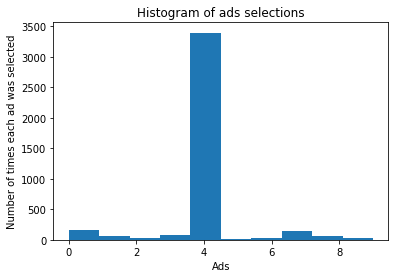

In [39]:
plot_ads_selected(ads_selected=ads_selected)

Now, let's try the Upper Confidence Bound algorithm to do the same:

### How the UCB Algorithm Works?

At the start of the campaign, we don't know what is the best arm or question. So we cannot distinguish or discriminate any arm or questions or something else. So the UCB algorithm assumes they all have the same observed average value. Then the algorithm creates confidence bound for each arm or questions. So it randomly picks any of the arms or ads. Then two things can happen: 1. the user clicks the ad and the arms gives reard or 2. does not. Let's say the ad did not have a click or the arm was a failure. So the observed average of the ad or arm will go down. And the confidence bound will also go down. If it had a click, the obsered average would go up and the confidence bound also goes up. By exploiting the best one we are decreasing the confidence bound. As we are adding more and more samples, the probability of other arms or ad doing will is also going up.

### Steps of the UCB algorithm:

**Step 1.** At each round n, we consider two numbers for each ad i:
<ul>
<li>$N_i(n)$ - the number of times the arm i was selected up to round n,</li>
<li>$R_i(n)$ - the sum of rewards of the arm i up to round n.</li>
</ul>
        
**Step 2.** From these two numbers we compute:

<ul>
<li>The average reward of arm i up to round n:
    
$$r_i(n) = \frac{R_i(n)}{N_i(n)}$$</li>
         
<li>the confidence interval $[r_i(n) - \Delta_i(n), r_i(n) + \Delta_i(n)]$ at round n with:</li>
    
$$\Delta_i(n) = \sqrt{\frac{3\log(n)}{2 N_i(n)}}$$
</ul>

**Step 3.** We select the arm i that has the maxium UCB r_i(n) + delta_i(n)

## Implementing UCB

Now, we'll implement the whole algorithm in Python based on the previous explanation.

In [27]:
# Implemeting UCB
N = dataset.shape[0] # 10000
d = dataset.shape[1] # 10

# is used to append the different types of ads selected in each round 
ads_selected = []

# is used to count the number of time an ad was selected 
numbers_of_selections = [0] * d

 # is used to calculate the cumulative sum of rewards at each round
sums_of_rewards = [0] * d

# Initizialition
total_reward = 0

for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n+1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400 #inf
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)
    # print('ads_selected')
    # print(ads_selected)
    numbers_of_selections[ad] += 1
    # print('numbers_of_selections')
    # print(numbers_of_selections)
    reward = dataset.values[n, ad]
    # print('reward')
    # print(reward)
    sums_of_rewards[ad] += reward
    # print('sums_of_reward')
    # print(sums_of_rewards)
    total_reward += reward
    # print('total_reward')
    # print(total_reward)

print('Total Reward for the UCB: {}'.format(total_reward))

Total Reward for the UCB: 2178


### Code Explanation

As we don't know any prior knowledge about the selection of each ad, we will take the first 10 rounds as trial rounds. So, we set the if condition: *if (numbers_of_selections[i] > 0)* so that the ads are selected at least once before entering into the main algorithm.

Then we implement the second step of the algorithm, computing the average reward of each ad i up to round n and the upper confidence bound for each ad.

**Note:** Here we applied a trick in else condition by taking the variable *upper_bound* to a huge number. This is because we want the first 10 rounds as trial rounds where 10 ads are selected at least once. This trick will help us to do so.

After 10 trial rounds, the algorithm will work as the steps explained earlier.

### Result

The total_reward for UCB is much bettern than random selection and indeed a smart exploration technique that can significantly improve our strategy to solve a MABP.

In [24]:
pd.Series(ads_selected).head(1500).value_counts(normalize=True)

4    0.346667
7    0.128000
0    0.095333
6    0.083333
1    0.068000
8    0.065333
3    0.065333
9    0.057333
5    0.045333
2    0.045333
dtype: float64

After just 1500 trials, UCB is already favoring Ad # 5 (index 4) which happen to be optimal ad, and gets the maximum return for the given problem.

### Visualizing the Result

Now we'll see what we get from our UCB model:

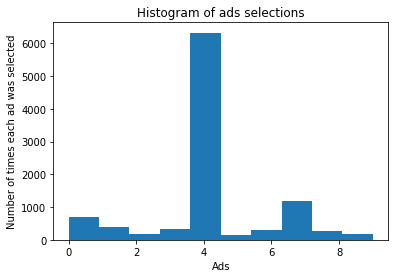

In [25]:
plot_ads_selected(ads_selected=ads_selected)

**Conclusion** 

From the above visualization, we can see that the fourth ad got the highest click. So our model advice us to place the fourth version of the ad to the user for getting the highest number of clicks.

**End Notes**

These algorithms are so simple and powerful that they are being used increasingly by even small tech companies, as the comptation resources required for them are often low. Going forward, there are other techniques based on probabilistic models such as Thompson Sampling.

## Thompson Sampling Algorithm

Thompson Sampling is a probabilistic algorithm based on Bayesian ideas. It is called sampling because it picks random samples from a probability distribution of each arm. This could be defined as a Beta Bernoulli sampler. Though Thompson sampling can be generalized to sample from any arbitrary distributions. But the Beta Bernoulli version of Thompson sampling is more intuitive and is actually the best options for many problems in practice. In this tutorial, we will use the Beta Benouli sampler.

### Algorithm Comparison: Upper Confidence bound vs. Thompson Sampling:

There is a significant difference between UCB and Thompson Sampling:

1. UCB is a deterministic algorithm whereas Thompson sampling is a probabalistic algorithm
2. In UCB you must incorporate the value at every round, you cannnot proceed to the next round without adjusting the value. In Thompson, you can accommodate delayed feedback. This means you can update the dataset for your MABP in a batch manner, that will save additional computing resource or cost of updateing the dataset each time. (Main Advantage of Thompson sampling algorithm)7

**Conclusion:** It comes out that the Thompson sampling has better emprical performance compared to the UCB algorithm.

### How the Thompson Sampling algorithm works?

Let's say we have three multi-armed bandits with the following distirbutions. Our expected value can be anywhere in the distribution. Now, this algorithm will choose samples from the above distribution using Bayesian Inference rules. First, it will run some trial rounds before doing the actual computation. After that, it will pick the samples from each of the distributions that have the highest value of the distribution. This will make an imaginary set of bandits. That means that this algorithm actually makes an auxiliary mechanism to solve the problem, that is, it will not create the machines at every round rather it will create the possible ways these machines could be recreated. With each trial, each takes a sample which has the highest distribution. And with each trial, the distribution will be changed. The distribution will get narrower as we have some information. After a huge number of rounds, we will get the narrowest distribution which we will take as the final outcome.

### Steps of the Thompson sampling algorithm:

**Step 1.**  At each reound *n*, we consider two numbers for each ad *i*:

<ul>
<li>$N_{i}^{1}(n)$ - the number of times the ad *i* got reward 1 up to round n,</li>
<li>$N_{i}^{0}(n)$ - the number of items the ad *i* got reward 0 up to round n.</li>
</ul>

**Step 2.** For each ad *i*, we take a random draw from the distribution below:
$$\theta_i(n) = \beta(N_{i}^{1}(n) + 1, N_{i}^{0}(n) + 1) $$

**Step 3.** We select the ad that has the highest $\theta_i(n)$.

## Implementing Thompson Sampling

Now, let's implement the Thompson Sampling code

In [36]:
# Implementing Thompson Sampling
N = dataset.shape[0] # 10000
d = dataset.shape[1] # 10

ads_selected = []

numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d

total_reward = 0

for n in range(0, N):
    ad = 0
    max_random = 0
    for i in range(0, d):
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        if random_beta > max_random:
            max_random = random_beta
            ad = i
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    if reward == 1:
        numbers_of_rewards_1[ad] += 1
    else:
        numbers_of_rewards_0[ad] += 1
    total_reward = total_reward + reward

### Visualizing the result

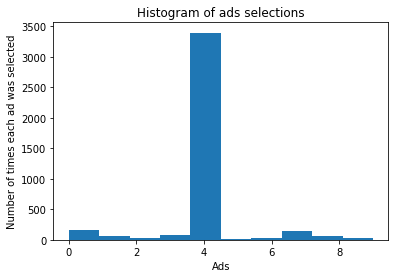

In [37]:
plot_ads_selected(ads_selected=ads_selected)